In [1]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score 

/home/valentxi/miniconda3/envs/msc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('./Data/cardiovascular_train.csv')
train_df.columns

Index(['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
       'SocioeconomicStatus'],
      dtype='object')

In [6]:
cols = ['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
       'SocioeconomicStatus']

nodes = [
    'Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
    'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
    'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
    'SocioeconomicStatus']

In [4]:
# WARNING ASK: isto existe pra q
from pgmpy.base import DAG
from pgmpy.estimators import BicScore

def initialize_graph(nodes,p=1):
  G = DAG()
  G.add_nodes_from(nodes=nodes)
  init = G.get_random(n_nodes=len(nodes), edge_prob=p)
  ls = []
  mapping = {}
  for k in range(len(nodes)):
      mapping[k] = nodes[k]
  for i,j in init.edges:
    ls.append((mapping[i],mapping[j]))
  ls
  G.add_edges_from(ebunch=ls) # G is the required initialization for the Hill Climbing method
  return G

In [ ]:
blacklist = ([
  ('Anxiety', 'Age'), ('BodyMassIndex', 'Age'), ('Depression', 'Age'),
  ('EducationLevel', 'Age'), ('Hypercholesterolemia', 'Age'), ('Hypertension', 'Age'),
  ('PhysicalActivity', 'Age'), ('Sex', 'Age'), ('SleepDuration', 'Age'), 
  ('SmokerProfile', 'Age'), ('SocioeconomicStatus', 'Age'),
  
  ('Anxiety', 'Sex'), ('BodyMassIndex', 'Sex'), ('Depression', 'Sex'),
  ('EducationLevel', 'Sex'), ('Hypercholesterolemia', 'Sex'), ('Hypertension', 'Sex'),
  ('PhysicalActivity', 'Sex'), ('Age', 'Sex'), ('SleepDuration', 'Sex'), 
  ('SmokerProfile', 'Sex'), ('SocioeconomicStatus', 'Sex'),
  ])

#fixed_edges = ([
#    ('PhysicalActivity','BodyMassIndex'), ('PhysicalActivity','Hypertension'), ('Age','Diabetes'),
#    ('BodyMassIndex','Diabetes'), ('BodyMassIndex','Hypertension'), ('BodyMassIndex','Hypercholesterolemia'),
#    ('SleepDuration','Depression'), ('SmokerProfile','Hypertension'), ('SmokerProfile','Hypercholesterolemia')])

k2 = K2Score(train_df) # Ver qual o score mais apropriado
es = HillClimbSearch(data=train_df)
#best_model = es.estimate(scoring_method=k2, black_list=blacklist, start_dag=initialize_graph(nodes=nodes, p=0.5))
#print('Edges:', best_model.edges())
#print('Bayesian score:', k2.score(best_model))
best_eval = 0

for x in range(0,15):
    current_model = es.estimate(scoring_method=k2, black_list=blacklist, start_dag=initialize_graph(nodes=nodes, p=0.5))
    curr_eval = k2.score(current_model)
    print(curr_eval)
    if curr_eval > best_eval:
        best_eval = curr_eval
        best_model = current_model

print(best_eval)




  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 51/1000000 [00:01<8:24:30, 33.03it/s] 


96267.140991134


  0%|          | 40/1000000 [00:01<7:59:30, 34.76it/s] 


43584.29758186033


  0%|          | 41/1000000 [00:01<8:02:26, 34.55it/s] 


43665.13366721221


  0%|          | 49/1000000 [00:01<7:45:45, 35.78it/s] 


43662.208850687755


  0%|          | 44/1000000 [00:01<8:13:43, 33.76it/s] 


48542.030910200774


  0%|          | 44/1000000 [00:01<8:20:44, 33.28it/s] 


95328.84402784018


  0%|          | 33/1000000 [00:01<8:43:48, 31.82it/s] 


48524.3381456225


  0%|          | 45/1000000 [00:01<8:33:51, 32.43it/s] 


95322.0453938452


  0%|          | 36/1000000 [00:01<8:07:00, 34.22it/s] 


48524.33814562251


  0%|          | 50/1000000 [00:01<7:36:06, 36.54it/s] 


95337.55383687215


  0%|          | 33/1000000 [00:01<9:19:01, 29.81it/s] 


43584.29758186033


  0%|          | 40/1000000 [00:01<8:05:14, 34.35it/s] 


43662.20885068776


  0%|          | 46/1000000 [00:01<8:57:42, 30.99it/s] 


95657.22911404159


  0%|          | 52/1000000 [00:01<7:30:57, 36.96it/s] 


95327.57593331423


  0%|          | 39/1000000 [00:01<7:50:58, 35.39it/s] 

43584.29758186033
96267.140991134


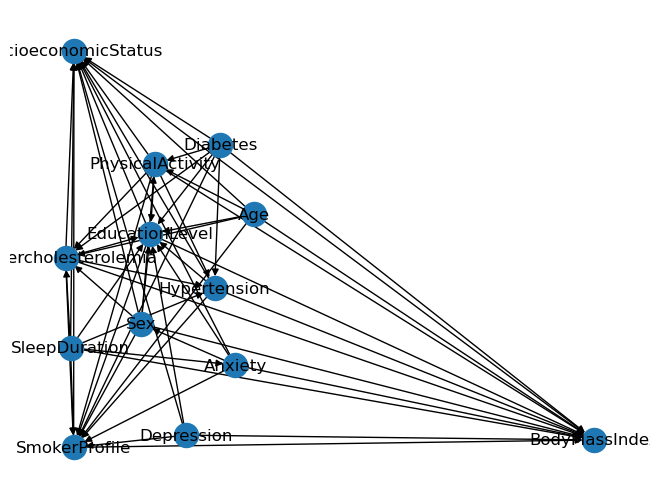

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw(nx.DiGraph(best_model.edges()), with_labels=True)
plt.draw()

In [ ]:
# - notas da blacklist
# - comentar os mais influenciados BMI, Smoker, SocioEconomic
# - So podiamos usar o hillclimb porque os dados n sao discretos e o exaustive search data a dimensionalodade dos dados
# - Local Maxima - Existem 2 grandes maximos no dominio dos nosso dados
# - Sem as limitacoes da blacklist o hillclimb escolheria outro maximo muito superior, dando muita enfase a influciar a idade, algo que  faz sentido
# - Comentar os nodes e a influencia das random initializations
# - 

#### Parameter Learning

In [12]:

dag_edges = set(best_model.edges())

In [13]:


bm = BayesianNetwork()
bm.add_nodes_from(nodes)
bm.add_edges_from(dag_edges)

In [14]:
from pgmpy.factors.discrete.CPD import TabularCPD

def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

In [15]:
# CPDs Maximum Likelyhood

mle_est_2 = MaximumLikelihoodEstimator(model=bm, data=train_df)
mle_est_2.get_parameters()

#for c in mle_est_2.get_parameters():  # demasiados parametros para dar print
#    print_full(c)

[<TabularCPD representing P(Age:6) at 0x7fe321ed4e00>,
 <TabularCPD representing P(Anxiety:2 | SleepDuration:3) at 0x7fe321f52870>,
 <TabularCPD representing P(BodyMassIndex:4 | Age:6, Anxiety:2, Depression:2, Diabetes:2, EducationLevel:3, Hypercholesterolemia:2, Hypertension:2, PhysicalActivity:2, Sex:2, SleepDuration:3, SmokerProfile:3, SocioeconomicStatus:3) at 0x7fe321dab590>,
 <TabularCPD representing P(Depression:2) at 0x7fe321f083e0>,
 <TabularCPD representing P(Diabetes:2) at 0x7fe321f0bcb0>,
 <TabularCPD representing P(EducationLevel:3 | Age:6, Anxiety:2, Depression:2, Diabetes:2, Hypercholesterolemia:2, Hypertension:2, PhysicalActivity:2, Sex:2, SleepDuration:3) at 0x7fe321dbff20>,
 <TabularCPD representing P(Hypercholesterolemia:2 | Age:6, Diabetes:2, PhysicalActivity:2, Sex:2, SleepDuration:3) at 0x7fe321dedc70>,
 <TabularCPD representing P(Hypertension:2 | Diabetes:2, Hypercholesterolemia:2, PhysicalActivity:2, SleepDuration:3) at 0x7fe321def920>,
 <TabularCPD representing

In [16]:
from pgmpy.estimators import BayesianEstimator

bm.fit(train_df, estimator=BayesianEstimator, prior_type='K2')

#for cpd in bm.get_cpds():
#    print(cpd)

In [ ]:
#for cpd in bm.get_cpds():
#    print_full(cpd)

In [20]:
from pgmpy.estimators import ExpectationMaximization
from pgmpy.models.BayesianNetwork import BayesianNetwork


train_df_preds = train_df.drop(columns=['Hypercholesterolemia', 'Hypertension', 'Diabetes'])
train_df['Diabetes'].value_counts()

Diabetes
No     3669
Yes     176
Name: count, dtype: int64

In [23]:

# defining the DAG

# estimate the CPDs of all variables
bm2.fit(df2, estimator=ExpectationMaximization, latent_card={'Q': 3}, max_iter=100, atol=1e-08, seed=4)

for cpd in bm2.get_cpds():
    print(cpd)

NameError: name 'df2' is not defined

In [24]:
bm2 = BayesianNetwork(dag_edges, 
                      latents={'Hypercholesterolemia', 'Hypertension', 'Diabetes'})

# estimate the CPDs of all variables
bm2.fit(train_df_preds, estimator=ExpectationMaximization, latent_card={'Hypercholesterolemia': 1, 'Hypertension': 1, 'Diabetes': 1}, max_iter=100, atol=1e-08, seed=4)

for cpd in bm.get_cpds():
    print(cpd)

  1%|          | 1/100 [00:06<11:03,  6.71s/it]


+------------+------------+
| Age(18-24) | 0.00753051 |
+------------+------------+
| Age(24-34) | 0.170345   |
+------------+------------+
| Age(34-44) | 0.366658   |
+------------+------------+
| Age(44-54) | 0.298364   |
+------------+------------+
| Age(54-64) | 0.154505   |
+------------+------------+
| Age(64-74) | 0.00259673 |
+------------+------------+
+---------------+-----+------------------------+
| SleepDuration | ... | SleepDuration(>9hours) |
+---------------+-----+------------------------+
| Anxiety(No)   | ... | 0.5                    |
+---------------+-----+------------------------+
| Anxiety(Yes)  | ... | 0.5                    |
+---------------+-----+------------------------+
+----------------------------+-----+
| Age                        | ... |
+----------------------------+-----+
| Anxiety                    | ... |
+----------------------------+-----+
| Depression                 | ... |
+----------------------------+-----+
| Diabetes                   | ...

In [ ]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(bm) # Temos mesmo de passar o predict, isto não é 
print(infer.query(['Diabetes'], evidence={'Age': '54-64', 'Anxiety': 'No'}))


+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9540 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0460 |
+---------------+-----------------+


In [ ]:
,BodyMassIndex,Depression,Diabetes,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus
54-64,No,Obese,No,No,2,No,No,Insufficiently Active,Male,6-9hours,Smoker,3
54-64,No,Normal,No,No,3,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1